In [1]:
# ====================================================
# 🔧 Environment Setup
# ====================================================
import torch, os
from transformers import AutoTokenizer
from scmt.modeling_somt import SchemaAugmentedSOMT
from scmt.modeling_utils import visualize_schemas
from scmt.schema_analysis import analyze_schemas
from scmt.viz_schemas import visualize_schemas as visualize_schemas_enhanced
from scmt.explain import generate_with_schema_attribution, schema_ablation_test
from FastChemTokenizerHF import FastChemTokenizerSelfies


# Path to the model checkpoint 
model_path = "./checkpoints/somt_w_test/"

# Load model and tokenizer
model = SchemaAugmentedSOMT.from_pretrained(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu")
tokenizer = FastChemTokenizerSelfies.from_pretrained("./tokenizer_vocab/selftok_reordered")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print(f"✅ Model loaded on {device}")


✅ Special tokens bound: 0 1 2 3 4
✅ Model loaded on cuda


In [2]:
@torch.no_grad()
def generate_text(model, tokenizer, prompt="", max_len=128, temperature=0.8):
    model.eval()
    device = next(model.parameters()).device
    if prompt == "":
        start_id = tokenizer.bos_token_id or tokenizer.eos_token_id or 0
        input_ids = torch.tensor([[start_id]], dtype=torch.long, device=device)
    else:
        input_ids = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=device)

    output = model.generate(
        tokenizer=tokenizer,
        input_ids=input_ids,
        max_length=max_len,
        temperature=temperature,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )
    return output if isinstance(output, str) else tokenizer.decode(output, skip_special_tokens=True)

print("\n🧪 Generation Samples:")
for i in range(3):
    print(f"Sample {i+1}: {generate_text(model, tokenizer)}")



🧪 Generation Samples:
Sample 1: [O] [=C] [Branch2] [Ring1] [P] [C] [O] [C] [Ring1]
Sample 2: [C] [O] [C] [=C] [C] [=C] [Branch2] [Ring2] [S] [C] [Branch2] [C] [C] [O] [C] [Ring2] [C] [N] [Branch1] [=N] [Ring1]
Sample 3: [O] [=C] [Branch1] [=Branch2] [C] [Ring1]


In [5]:
import selfies as sf

tokens = "[O] [=C] [Branch1] [=Branch2] [C] [Ring1]"
tokens = tokens.replace(" ", "")
print(sf.decoder(tokens))

O=C=C


In [6]:
# Basic textual interpretation
visualize_schemas(model, tokenizer, top_k=10)



=== Schema Interpretability (top 10 tokens per schema) ===

Schema 00: [O] [=C] [N] [C] (0.069) | [C] [O] [C] [=C] [C] [=C] [N] [=C] (0.064) | [N] [C] [=N] [C] (0.052) | [Cl] [C] [=C] [C] [=C] (0.045) | [C] [C] [C] [C] [N] (0.044) | [C] [=C] [C] [N] [C] (0.036) | [C] [C] [C] [=N] [C] (0.035) | [C] [C] [C] [=Branch1] [C] [=O] (0.034) | [C] [N] [C] [=C] [Branch2] (0.031) | [C] [N] [C] [=Branch1] [C] [=O] [C] (0.029)
Schema 01: [C] [C] [Branch1] [C] [C] [N] [C] (0.070) | [C] [C] [C] [=C] [C] (0.054) | [O] [=C] [N] [C] (0.053) | [C] [O] [C] (0.051) | [C] [C] [C] [N] [C] (0.048) | [Cl] [C] [=C] [C] [=C] [Branch2] (0.046) | [N] [C] [C] (0.041) | [=S] (0.035) | [N] [C] [=Branch1] [C] [=O] [C] (0.035) | [F] [C] [=C] [C] [=C] [Branch2] (0.032)
Schema 02: [O] [=C] [C] [=Branch1] [C] [=O] (0.133) | [O] [=S] [=Branch1] [C] [=O] [Branch1] (0.129) | [C] [C] [Branch1] [C] [C] [Branch2] (0.125) | [C] [N] [C] [=C] [Branch2] (0.121) | [O] [=C] [N] [C] (0.113) | [C] [C] [=C] (0.107) | [C] [C] [S] (0.104


🔍 Schema 0


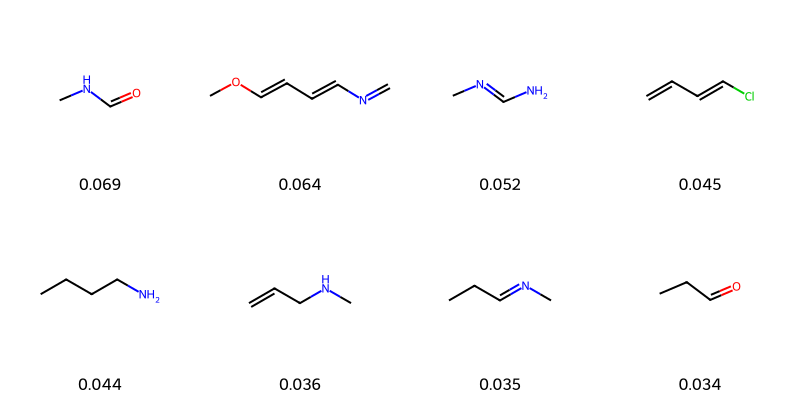


🔍 Schema 1


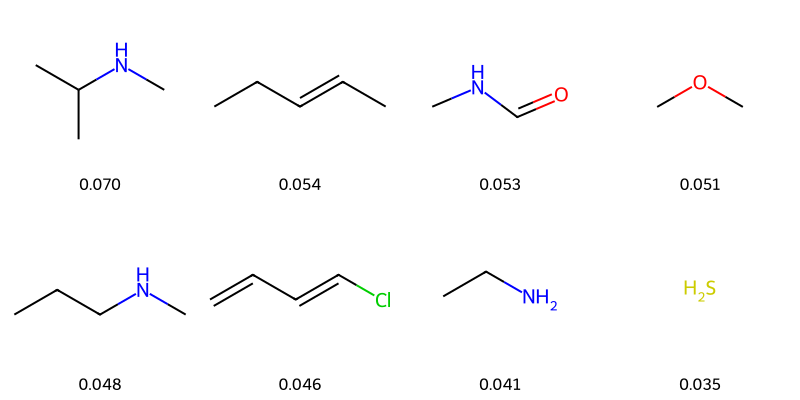


🔍 Schema 2


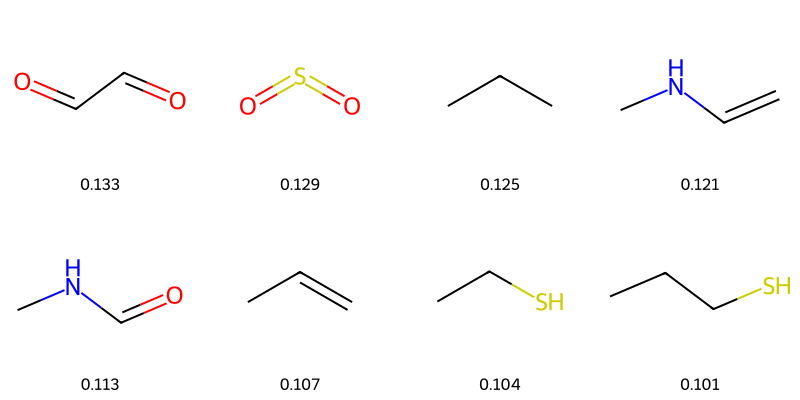


🔍 Schema 3


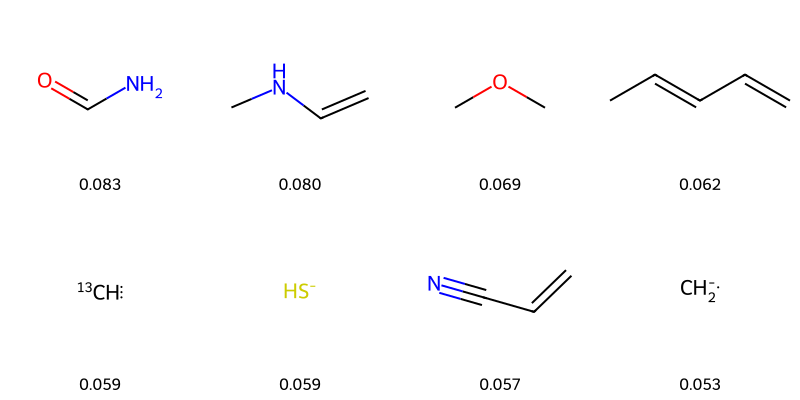


🔍 Schema 4


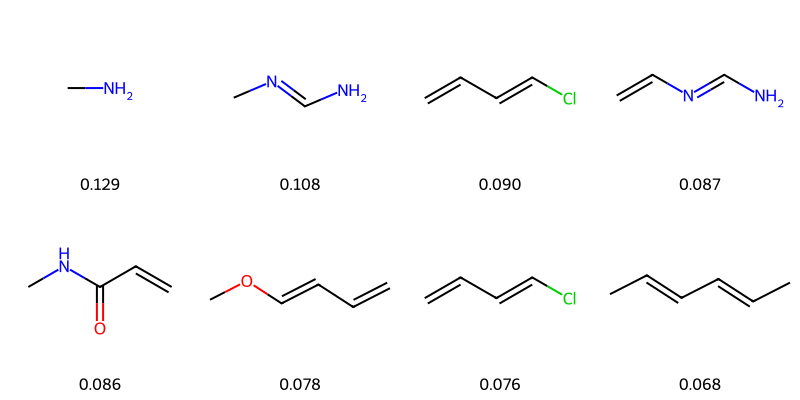


🔍 Schema 5


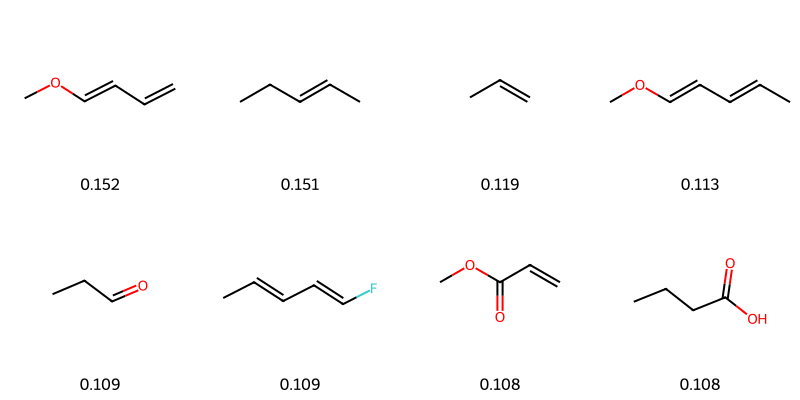


🔍 Schema 6


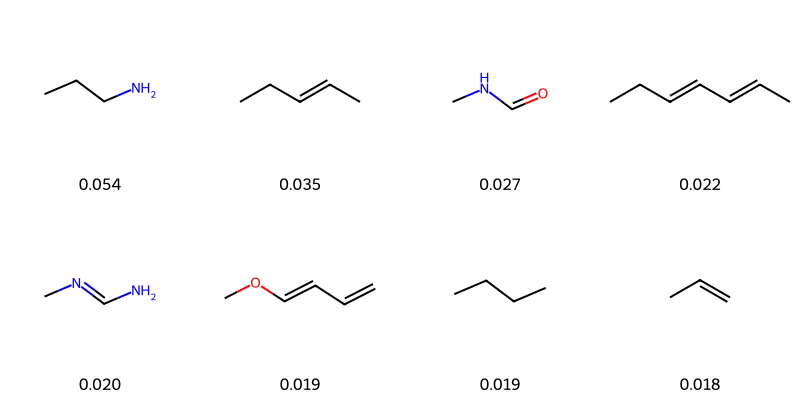


🔍 Schema 7


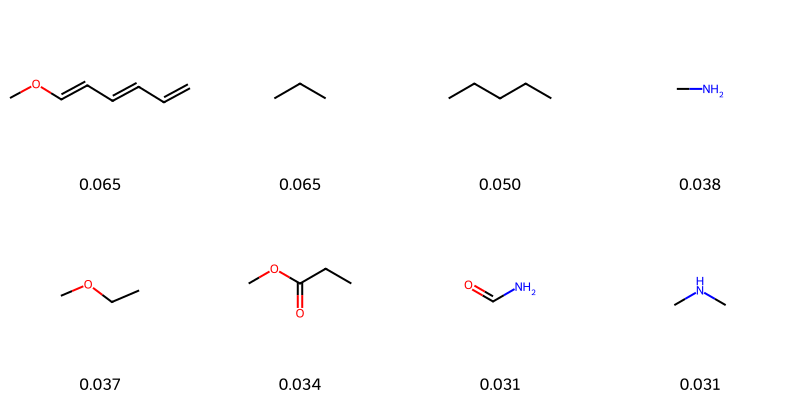


🔍 Schema 8


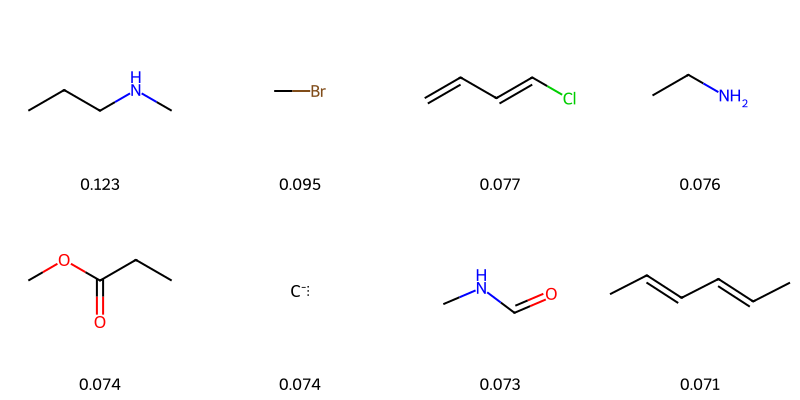


🔍 Schema 9


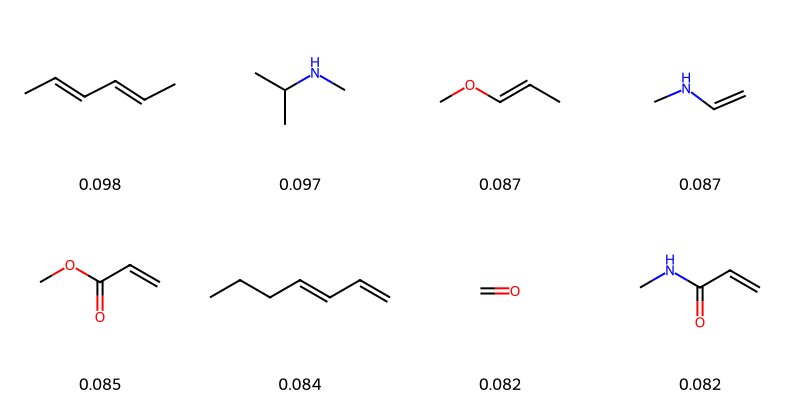


🔍 Schema 10


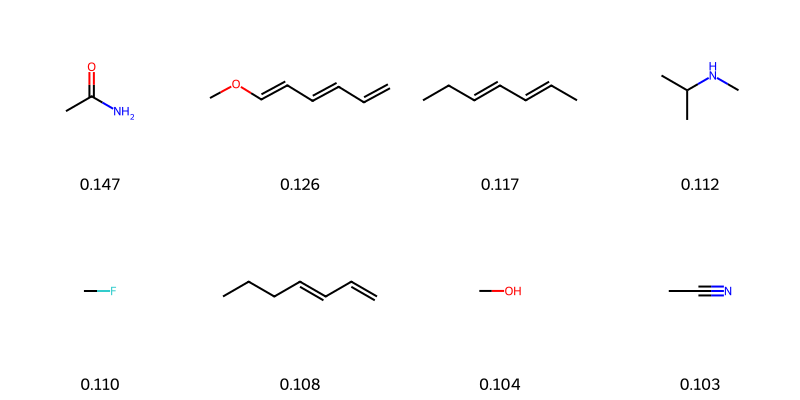


🔍 Schema 11


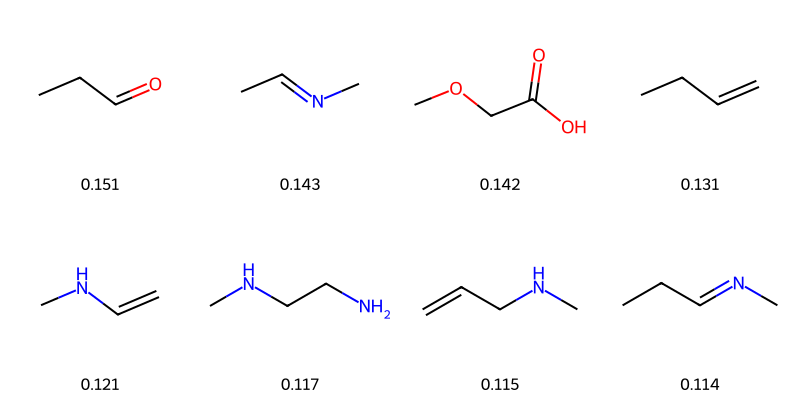


🔍 Schema 12


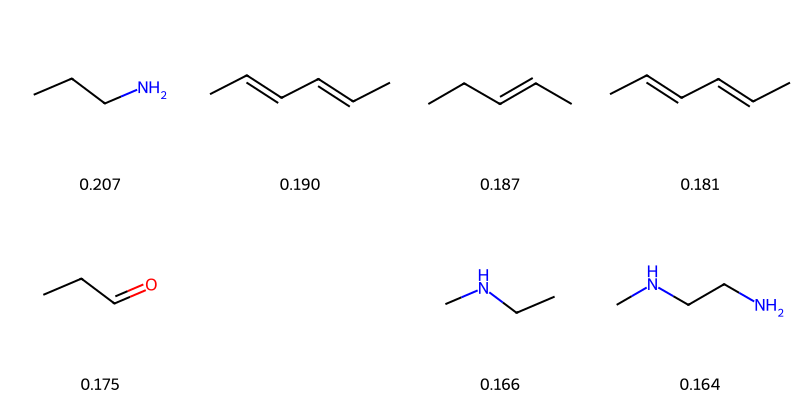


🔍 Schema 13


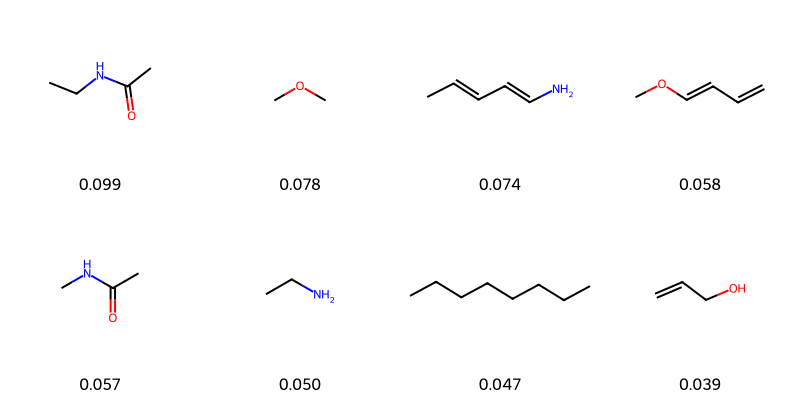


🔍 Schema 14


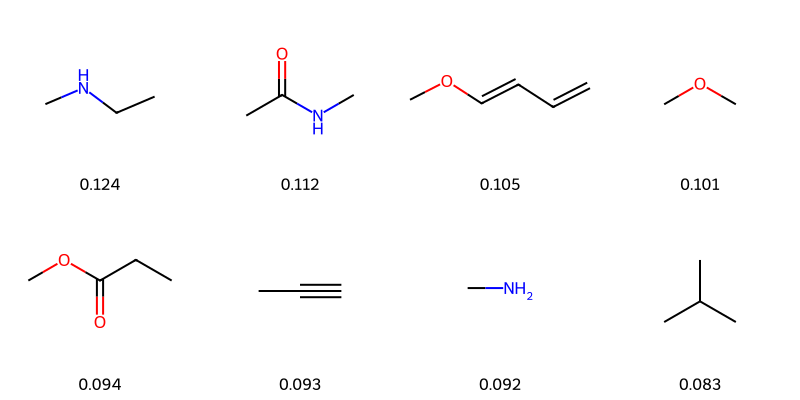


🔍 Schema 15


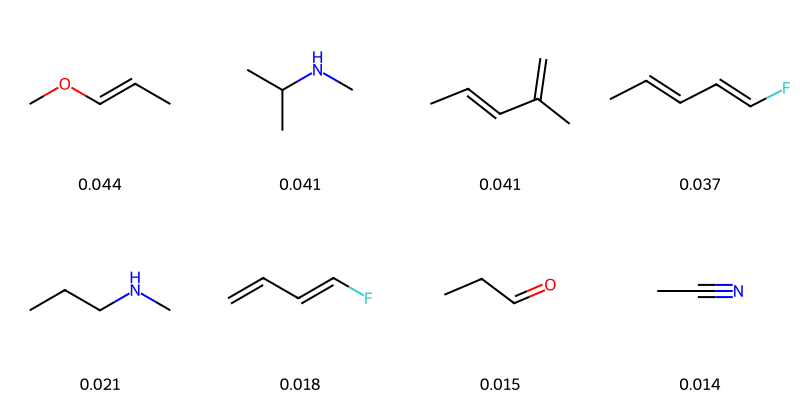


🔍 Schema 16


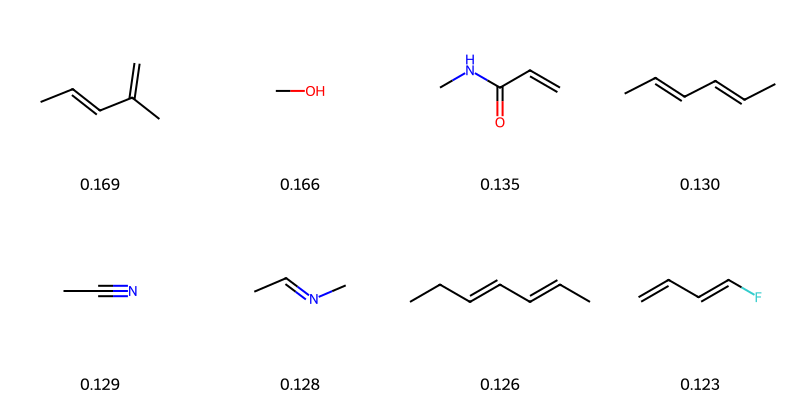


🔍 Schema 17


[10:09:28] unsupported number of radical electrons 4


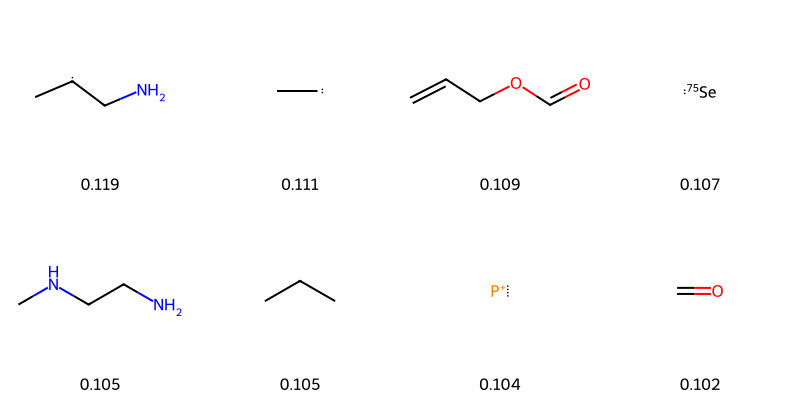


🔍 Schema 18


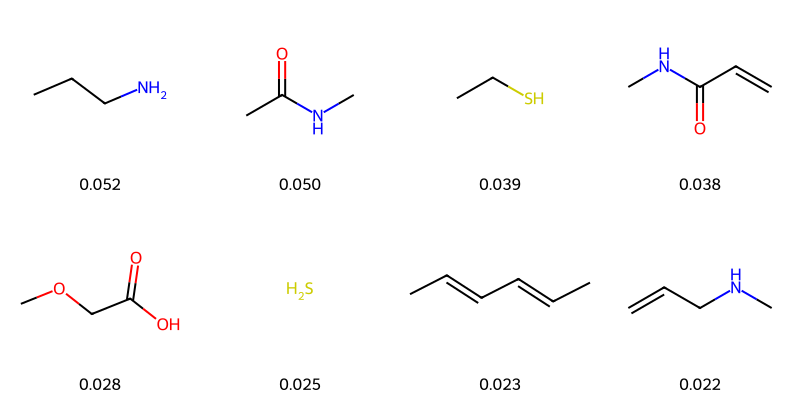


🔍 Schema 19


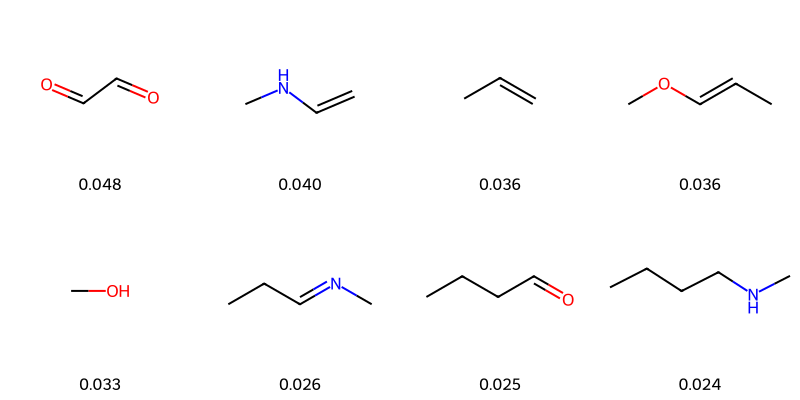


🔍 Schema 20


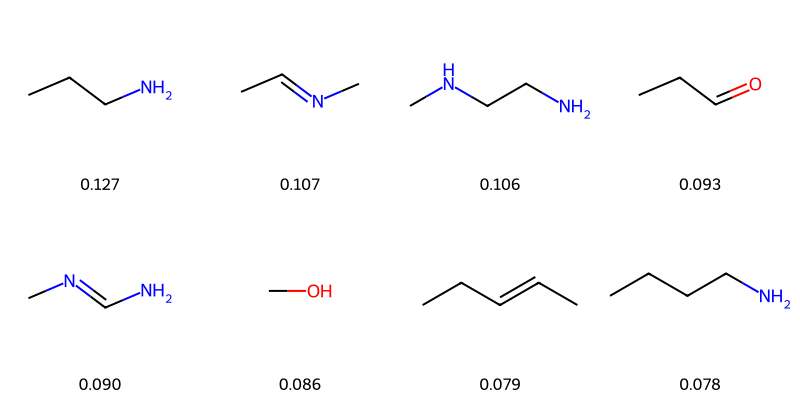


🔍 Schema 21


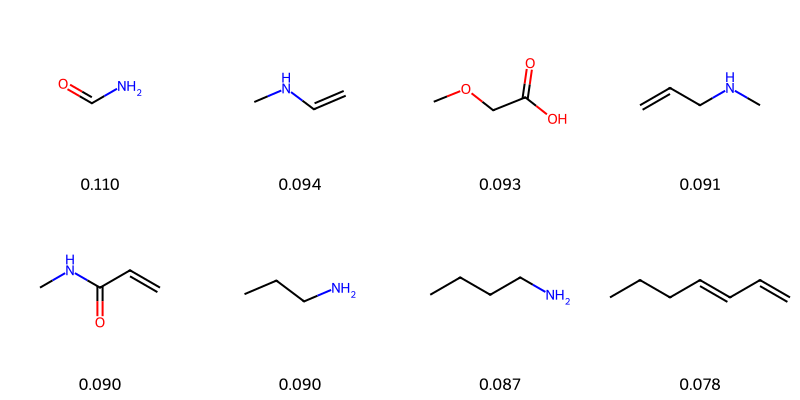


🔍 Schema 22


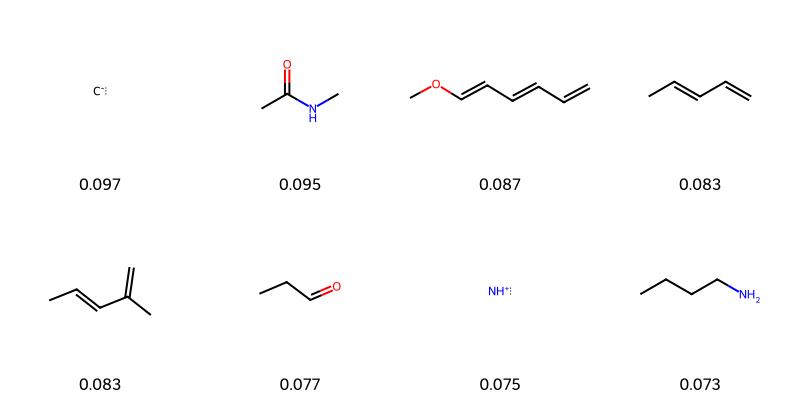


🔍 Schema 23


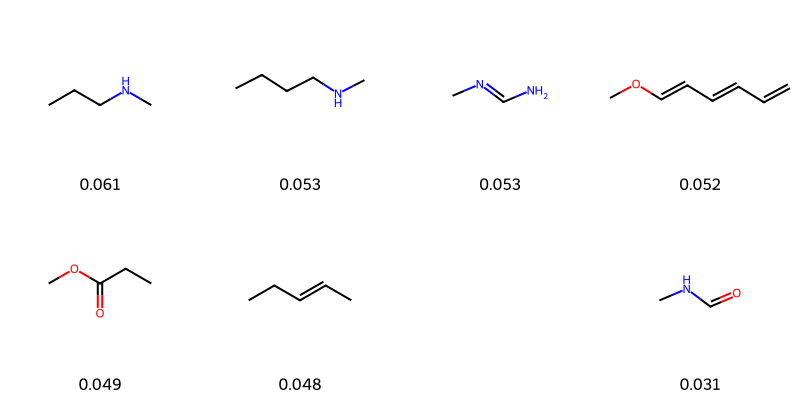


🔍 Schema 24


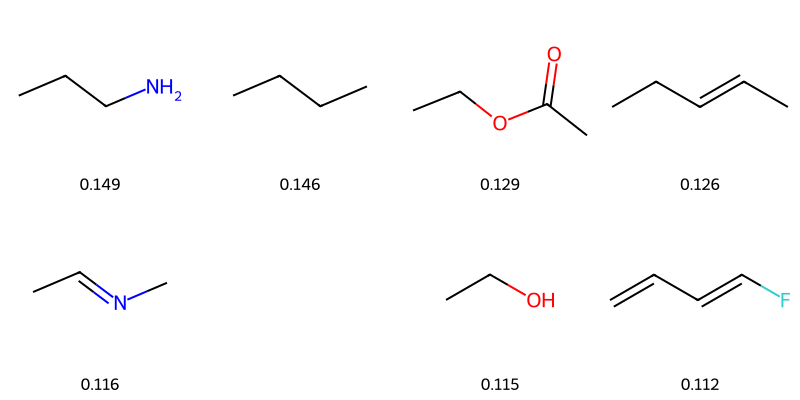


🔍 Schema 25


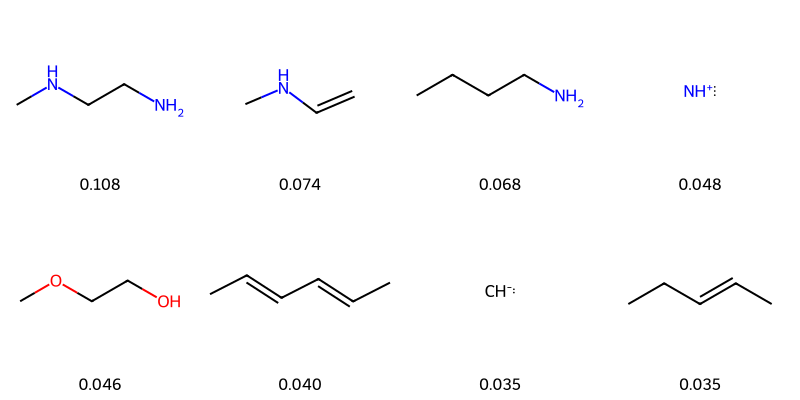


🔍 Schema 26


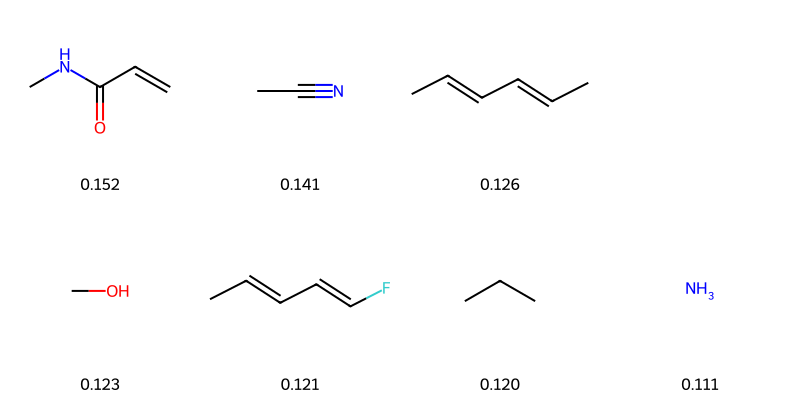


🔍 Schema 27


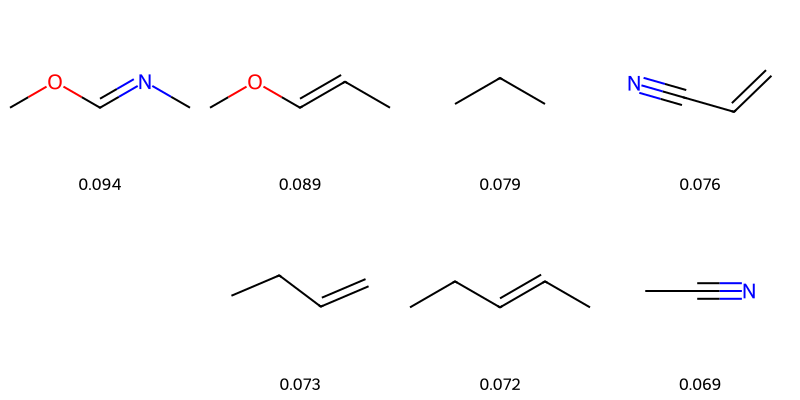


🔍 Schema 28


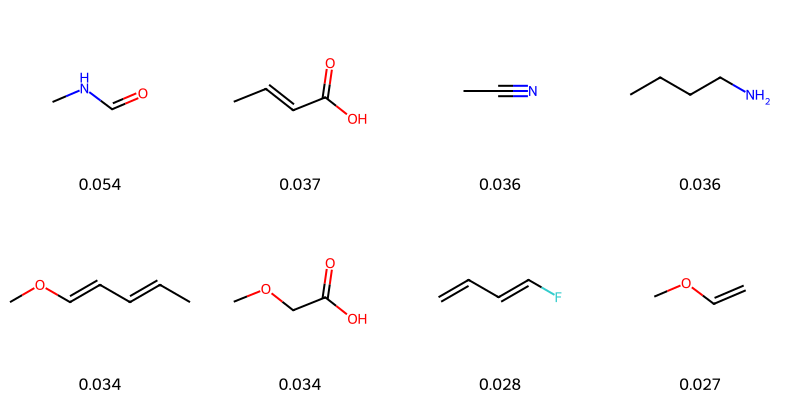


🔍 Schema 29


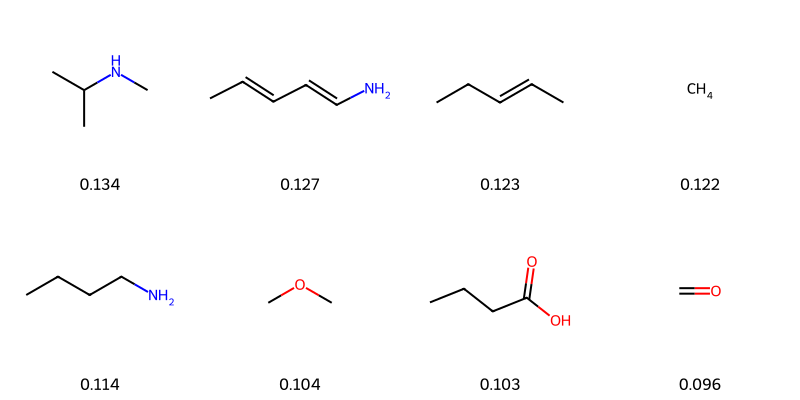


🔍 Schema 30


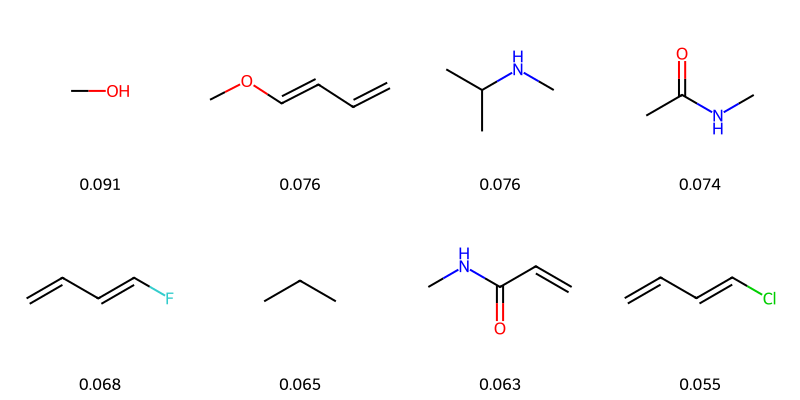


🔍 Schema 31


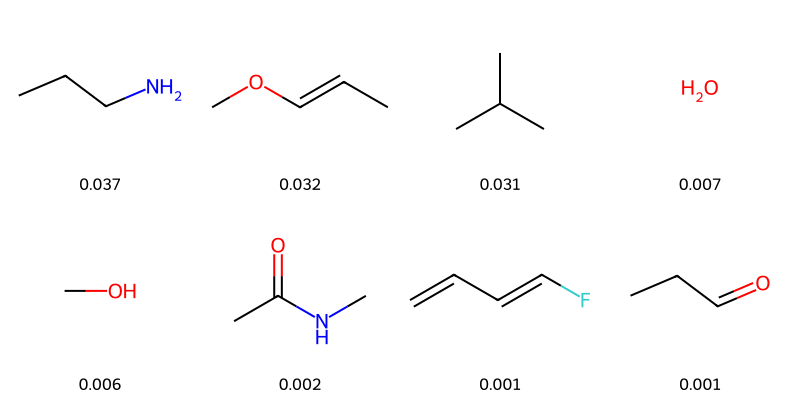

In [7]:
import torch
import torch.nn.functional as F
import selfies as sf
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")  # suppress RDKit warnings

@torch.no_grad()
def get_schema_top_tokens(model, tokenizer, top_k=8):
    model.eval()
    device = next(model.parameters()).device

    embed_matrix = model.embed.weight.data  # (V, D)
    projected_tokens = model.key_proj(embed_matrix)  # (V, D)

    schema_norm = F.normalize(model.schema_keys, p=2, dim=-1)  # (S, D)
    token_norm = F.normalize(projected_tokens, p=2, dim=-1)     # (V, D)

    sim = torch.mm(schema_norm, token_norm.T)  # (S, V)

    results = []
    for i in range(sim.size(0)):
        top_vals, top_ids = torch.topk(sim[i], k=top_k, largest=True)
        tokens_list = []
        for tid, val in zip(top_ids, top_vals):
            token_str = tokenizer.decode([tid.item()])
            tokens_list.append((token_str, val.item()))
        results.append(tokens_list)
    return results

def render_schema_molecules(schema_results, max_mols_per_schema=8):
    for schema_idx, token_entries in enumerate(schema_results):
        print(f"\n🔍 Schema {schema_idx}")
        mols = []
        labels = []

        for token_str, similarity in token_entries[:max_mols_per_schema]:
            # Clean token string: remove spaces, ensure valid SELFIES
            selfies_str = token_str.replace(" ", "")
            
            try:
                # Decode SELFIES → SMILES
                smiles = sf.decoder(selfies_str)
                
                # Convert SMILES → RDKit Mol
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    raise ValueError("Invalid SMILES")
                
                mols.append(mol)
                labels.append(f"{similarity:.3f}")
                
            except Exception as e:
                # If decoding fails, show placeholder
                print(f"⚠️  Failed to decode: '{token_str}' → {e}")
                # Optionally append a dummy molecule or skip
                continue

        if mols:
            # Render grid
            img = Draw.MolsToGridImage(
                mols,
                molsPerRow=min(len(mols), 4),
                subImgSize=(200, 200),
                legends=labels,
                useSVG=False  # set True if you prefer SVG
            )
            display(img)
        else:
            print("❌ No valid molecules to display for this schema.")

schema_results = get_schema_top_tokens(model, tokenizer, top_k=8)
render_schema_molecules(schema_results)

In [5]:
visualize_schemas_enhanced(
    model=model,
    tokenizer=tokenizer,
    top_k=10,
    mask_stop=True,
    export="html",  # or "latex"
    export_path=f"{model_path}/schemas_viz.html"
)


Schema 00: [O] [=C] [N] [C] (0.069) | [C] [O] [C] [=C] [C] [=C] [N] [=C] (0.064) | [N] [C] [=N] [C] (0.052) | [Cl] [C] [=C] [C] [=C] (0.045) | [C] [C] [C] [C] [N] (0.044) | [C] [=C] [C] [N] [C] (0.036) | [C] [C] [C] [=N] [C] (0.035) | [C] [C] [C] [=Branch1] [C] [=O] (0.034) | [C] [N] [C] [=C] [Branch2] (0.031) | [C] [N] [C] [=Branch1] [C] [=O] [C] (0.029)
Schema 01: [C] [C] [Branch1] [C] [C] [N] [C] (0.070) | [C] [C] [C] [=C] [C] (0.054) | [O] [=C] [N] [C] (0.053) | [C] [O] [C] (0.051) | [C] [C] [C] [N] [C] (0.048) | [Cl] [C] [=C] [C] [=C] [Branch2] (0.046) | [N] [C] [C] (0.041) | [=S] (0.035) | [N] [C] [=Branch1] [C] [=O] [C] (0.035) | [F] [C] [=C] [C] [=C] [Branch2] (0.032)
Schema 02: [O] [=C] [C] [=Branch1] [C] [=O] (0.133) | [O] [=S] [=Branch1] [C] [=O] [Branch1] (0.129) | [C] [C] [Branch1] [C] [C] [Branch2] (0.125) | [C] [N] [C] [=C] [Branch2] (0.121) | [O] [=C] [N] [C] (0.113) | [C] [C] [=C] (0.107) | [C] [C] [S] (0.104) | [C] [C] [C] [S] (0.101) | [C] [C] [=C] [C] [Branch1] [C] 

🔍 Found 0 redundant schema pairs (cos>0.95)
💡 Avg intra-cluster cosine: 0.364
✅ Saved schema analysis → ./checkpoints/somt_w_test//schema_analysis.json


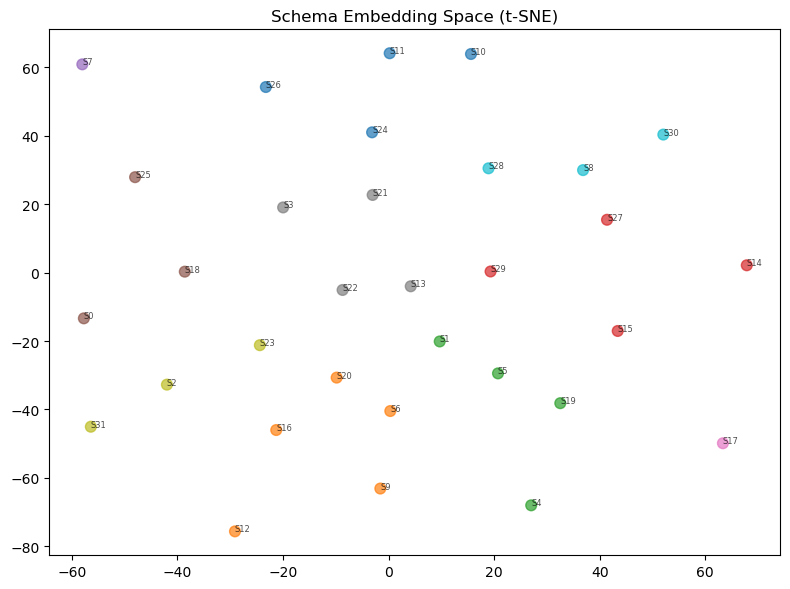

{'positions': [[-57.733055114746094, -13.374176979064941], [9.685075759887695, -20.12787628173828], [-41.995182037353516, -32.755104064941406], [-19.981229782104492, 19.0521297454834], [27.01734733581543, -68.03965759277344], [20.726930618286133, -29.46461296081543], [0.3247983753681183, -40.474273681640625], [-58.02374267578125, 60.88441467285156], [36.84231948852539, 29.961437225341797], [-1.5639997720718384, -63.132545471191406], [15.608388900756836, 63.9041633605957], [0.20715858042240143, 64.12821197509766], [-29.103439331054688, -75.65541076660156], [4.194665908813477, -4.002753734588623], [67.859375, 2.138913869857788], [43.40675735473633, -17.069734573364258], [-21.285097122192383, -46.02732467651367], [63.33646011352539, -49.89309310913086], [-38.61148452758789, 0.2684524655342102], [32.52717208862305, -38.17782211303711], [-9.840651512145996, -30.70081329345703], [-3.023052930831909, 22.69799041748047], [-8.715250968933105, -5.082056522369385], [-24.390504837036133, -21.21987

In [8]:
analysis = analyze_schemas(model, tokenizer, top_k=10, save_path=f"{model_path}/schema_analysis.json")
print(analysis)  # Print the analysis summary

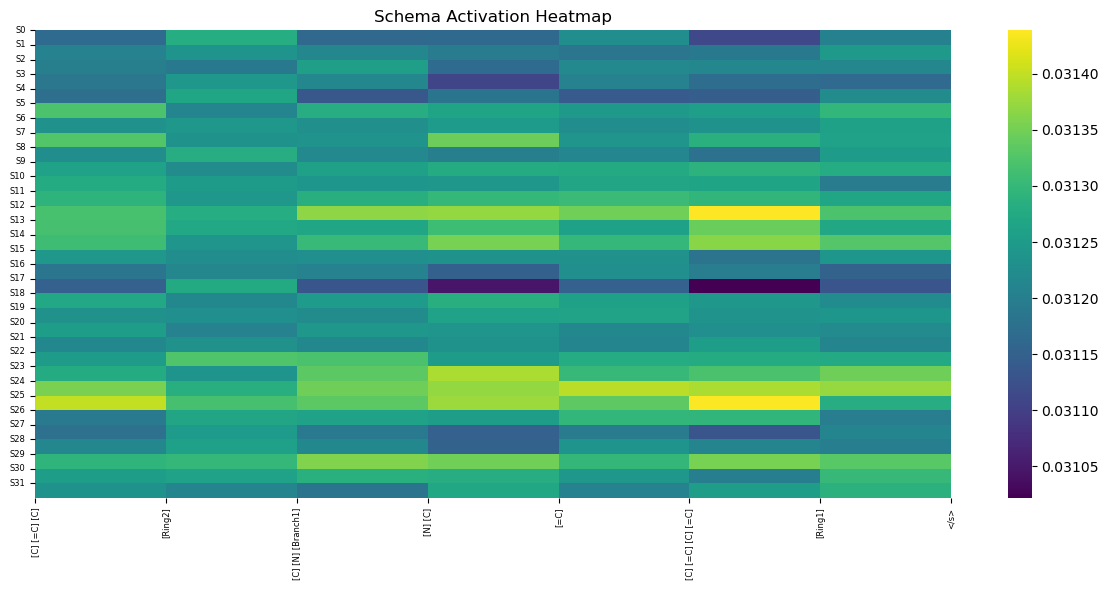

[C] [=C] [C] [Ring2] [C] [N] [Branch1] [N] [C] [=C] [C] [=C] [C] [=C] [Ring1]


In [12]:
result = generate_with_schema_attribution(
    model,
    tokenizer,
    prompt="[C] [=C] [C]",
    max_len=90,
    temperature=1,
    visualize_heatmap=True
)
print(result['text'])